In [1361]:
import math
import scipy.io
import scipy.signal
import scipy.fft
import matplotlib.pyplot as plt
import numpy as np

In [1362]:
#Loading the audio file
signal = scipy.io.wavfile.read('signal.wav')
numSamples = len(signal[1])
print('Sample rate is:', signal[0], 'and the number of signals is:', numSamples)
print('This corresponds to', numSamples/signal[0], 'seconds')

Sample rate is: 16000 and the number of signals is: 18091
This corresponds to 1.1306875 seconds


In [1363]:
#Mean subtraction
mean = np.mean(signal[1])
print(mean)
meanSub = signal[1] - mean

11756.525786302582


In [1364]:
#Pre-emphasis
b = 0.97 #given constant    
meanSub = np.insert(meanSub, 0, 0)
preEmp = meanSub[1:]-b*meanSub[:-1]

In [1365]:
#Computing frames
#Window length 𝐿 set to 25 milliseconds: this is (25/1000)/(1/16000) = 400 samples
#Window shift 𝑆 set to 10 milliseconds: this is (10/1000)/(1/16000) = 160 samples
L = 400
S = 160
#dimensions of the return array are 1+ceil((numSamples-L)/S) rows by L samples
frames = np.zeros((1 + math.ceil((numSamples-L)/S), L))
for k in range(frames.shape[0]):
    for n in range(L):
        ind = k*S+n
        if  ind<numSamples:
            frames[k][n] = preEmp[ind]
        else:
            break
print(frames.shape)

(112, 400)


In [1366]:
#Applying window function
window = scipy.signal.hamming(L)
frames*=window
print(frames.shape)

(112, 400)


In [1367]:
#Computing the Fourier transform
N = 512 #number of DFT points, given
fourier = scipy.fft.fft(frames, N)
print(fourier.shape)

(112, 512)


In [1368]:
#Computing the magnitude and power spectra
magnitude = np.abs(fourier)
print(magnitude.shape)
power = np.square(magnitude)
print(power.shape)

(112, 512)
(112, 512)


(23, 257)
(112, 23)


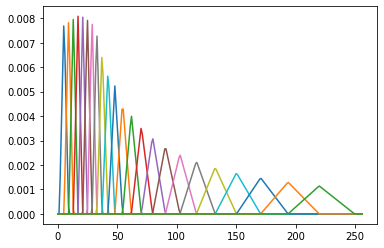

In [1369]:
#Mel-filterbank application
mel_filters = np.array(np.load('mel_filters.npy'))
plt.plot(mel_filters.T)
print(mel_filters.shape)
#Want to take the first 257 values for each frame and matrix multiply by the transpose of the mel filters array
mel = np.matmul(power[:,:257], np.swapaxes(mel_filters, 0, 1))
print(mel.shape)

In [1370]:
#taking the log
mellog = np.maximum(np.full(mel.shape, -50), np.log(mel))
print (mellog.shape)

(112, 23)


In [1371]:
#Computing the DCT and “liftering”:
numCoeff = 13 #given
c = np.zeros((mellog.shape[0], numCoeff))
for window in range(c.shape[0]):
    for i in range(c.shape[1]):
        c[window][i] = np.sum(mellog[window]*np.cos((np.arange(mellog.shape[1])+0.5)*np.pi*i/23))
print(c.shape)
print(c)

(112, 13)
[[ 5.39121421e+02 -1.88310069e+01  1.10734460e+00 ...  3.42458454e+00
   3.04125377e+00 -9.07008924e-01]
 [ 5.39289153e+02 -1.46975456e+01  2.91332735e+00 ...  1.68826014e+00
   2.82848659e+00  3.65086968e+00]
 [ 5.42237676e+02 -1.27343226e+01  3.82066903e+00 ...  1.84973034e+00
   5.42737464e+00  3.60466165e+00]
 ...
 [ 5.53221588e+02 -3.96558941e+00  1.15872326e+01 ...  6.99969974e-01
  -8.03559302e-01  1.78997048e+00]
 [ 6.33786166e+02 -3.31641578e+01 -6.26768414e+00 ...  1.50231180e+00
  -1.18006351e+00  1.42263382e+00]
 [ 6.41720883e+02 -3.18541353e+01 -4.99451925e+00 ...  8.15009283e-01
  -5.71254995e-01  2.26657194e+00]]


In [1372]:
#putting it all together

(13, 112)


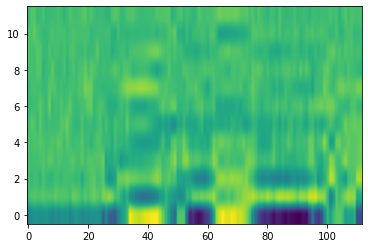

In [1373]:
#Visualizing MFCC features
cdata = np.swapaxes(c, 0, 1)
print(cdata.shape)
plt.imshow(cdata[1:13], origin='lower', aspect='auto')

[[1.13686838e-13 0.00000000e+00 0.00000000e+00 ... 7.10542736e-15
  3.55271368e-15 7.10542736e-15]
 [0.00000000e+00 2.84217094e-14 0.00000000e+00 ... 3.55271368e-15
  0.00000000e+00 7.10542736e-15]
 [2.27373675e-13 5.68434189e-14 0.00000000e+00 ... 3.55271368e-15
  3.55271368e-15 3.55271368e-15]
 ...
 [0.00000000e+00 2.84217094e-14 1.42108547e-14 ... 7.10542736e-15
  1.42108547e-14 8.88178420e-15]
 [0.00000000e+00 0.00000000e+00 1.42108547e-14 ... 3.55271368e-15
  3.55271368e-15 3.55271368e-15]
 [0.00000000e+00 0.00000000e+00 2.84217094e-14 ... 3.55271368e-15
  3.55271368e-15 7.10542736e-15]]
7.262548232703948e-28


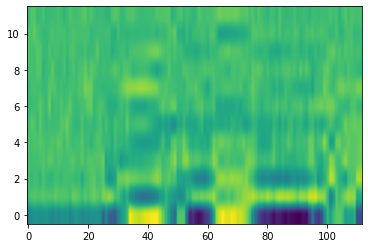

In [1374]:
#Calculating diffs and MSE
reference = np.load('reference_mfcc.npy')
diffs = np.absolute(c-reference)
print(diffs)
mse = np.mean(np.square(diffs))
print(mse)
#plot reference solution
plt.imshow(np.swapaxes(reference, 0, 1)[1:13], origin='lower', aspect='auto')

(23, 112)


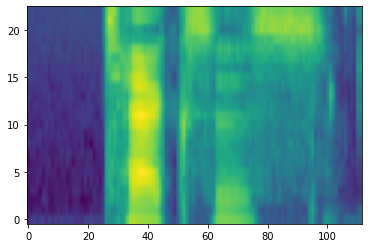

In [1375]:
#printing log mel mfsc
mellogdata = np.swapaxes(mellog, 0, 1)
print(mellogdata.shape)
plt.imshow(mellogdata, origin='lower', aspect='auto')

(512, 112)


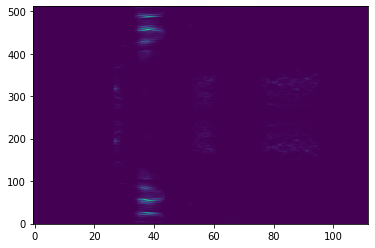

In [1376]:
#printing log power spectra
logpower = np.maximum(np.full(power.shape, -50), np.log(power))
logpowerdata = np.swapaxes(power, 0, 1)
print(logpowerdata.shape)
plt.imshow(logpowerdata, origin='lower', aspect='auto')

(13, 1128)


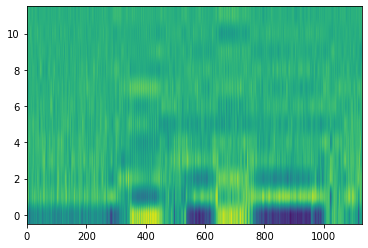

In [1377]:
# Visualizing coefficients with smaller window size

#Window length 𝐿 set to 4 milliseconds: this is (4/1000)/(1/16000) = 64 samples
#Window shift 𝑆 set to 1 milliseconds: this is (1/1000)/(1/16000) = 16 samples
L = 64
S = 16
frames = np.zeros((1 + math.ceil((numSamples-L)/S), L))
for k in range(frames.shape[0]):
    for n in range(L):
        ind = k*S+n
        if  ind<numSamples:
            frames[k][n] = preEmp[ind]
        else:
            break
window = scipy.signal.hamming(L)
frames*=window
N = 512 #number of DFT points, given
fourier = scipy.fft.fft(frames, N)
magnitude = np.abs(fourier)
power = np.square(magnitude)
mel_filters = np.array(np.load('mel_filters.npy'))
mel = np.matmul(power[:,:257], np.swapaxes(mel_filters, 0, 1))
mellog = np.maximum(np.full(mel.shape, -50), np.log(mel))
numCoeff = 13 #given
c = np.zeros((mellog.shape[0], numCoeff))
for window in range(c.shape[0]):
    for i in range(c.shape[1]):
        c[window][i] = np.sum(mellog[window]*np.cos((np.arange(mellog.shape[1])+0.5)*(np.pi*i/23)))
cdata2 = np.swapaxes(c, 0, 1)
print(cdata2.shape)
plt.imshow(cdata2[1:13], origin='lower', aspect='auto')

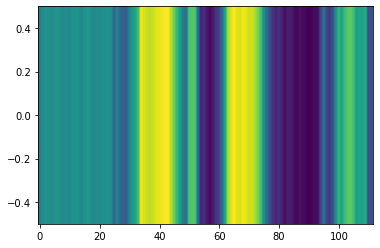

In [1378]:
#plotting C1
plt.imshow([cdata[1]], origin='lower', aspect='auto')